<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Story" data-toc-modified-id="Data-Story-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Story</a></span><ul class="toc-item"><li><span><a href="#Distribution-vs.-Weather,-Season,-Working-Day" data-toc-modified-id="Distribution-vs.-Weather,-Season,-Working-Day-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Distribution vs. Weather, Season, Working Day</a></span></li><li><span><a href="#Distribution-vs.-Temperature" data-toc-modified-id="Distribution-vs.-Temperature-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Distribution vs. Temperature</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Hourly-Distribution" data-toc-modified-id="Hourly-Distribution-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Hourly Distribution</a></span></li><li><span><a href="#Monthly-Distribution" data-toc-modified-id="Monthly-Distribution-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Monthly Distribution</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# Read the data
mydata = pd.read_csv('./../Data/train.csv', parse_dates=True, index_col='datetime')
testdata = pd.read_csv('./../Data/test.csv', parse_dates=True, index_col='datetime')

# Converting into categorical data
category_list = ['season', 'holiday', 'workingday', 'weather']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')
    
# Mapping numbers to understandable text
season_dict = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
weather_dict = {1:'Clear', 2:'Misty+Cloudy', 3:'Light Snow/Rain', 4:'Heavy Snow/Rain'}
mydata['season'] = mydata['season'].map(season_dict)
mydata['weather'] = mydata['weather'].map(weather_dict)

testdata['season'] = testdata['season'].map(season_dict)
testdata['weather'] = testdata['weather'].map(weather_dict)



# Data Story

## Distribution vs. Weather, Season, Working Day 
Let us see how 'count' = number of bikes rented varies across the various categorical data (weather, season, working day)

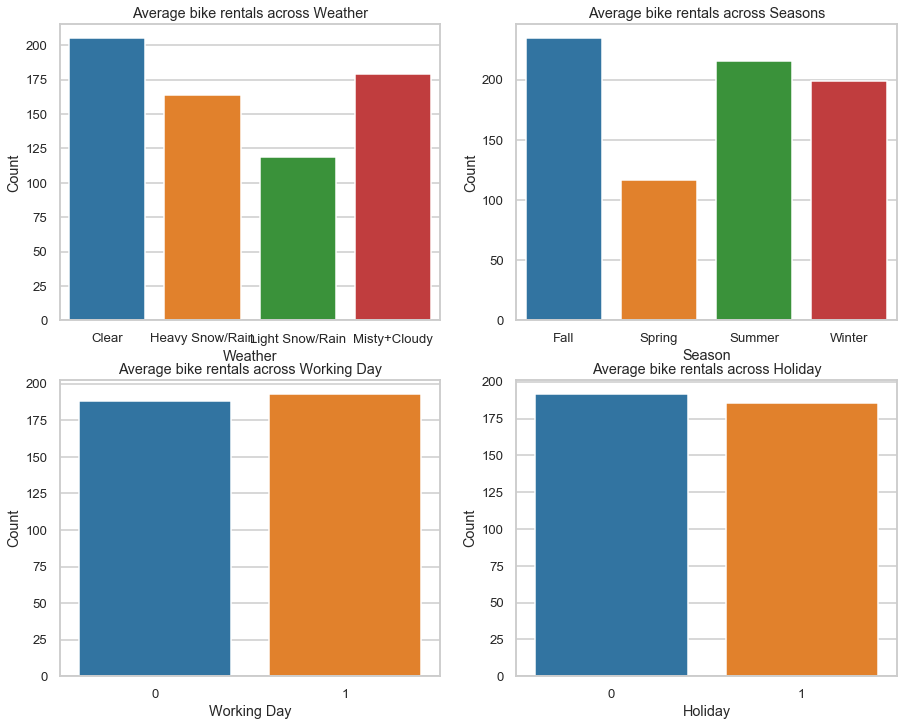

In [2]:
# Average values across each of the categorical columns 
fig = plt.figure(figsize=(15, 12))
axes = fig.add_subplot(2, 2, 1)
group_weather = pd.DataFrame(mydata.groupby(['weather'])['count'].mean()).reset_index()
sns.barplot(data=group_weather, x='weather', y='count', ax=axes)
axes.set(xlabel='Weather', ylabel='Count', title='Average bike rentals across Weather')

axes = fig.add_subplot(2, 2, 2)
group_season = pd.DataFrame(mydata.groupby(['season'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='season', y='count', ax=axes)
axes.set(xlabel='Season', ylabel='Count', title='Average bike rentals across Seasons')

axes = fig.add_subplot(2, 2, 3)
group_workingday = pd.DataFrame(mydata.groupby(['workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_workingday, x='workingday', y='count', ax=axes)
axes.set(xlabel='Working Day', ylabel='Count', title='Average bike rentals across Working Day')

axes = fig.add_subplot(2, 2, 4)
group_season = pd.DataFrame(mydata.groupby(['holiday'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='holiday', y='count', ax=axes)
axes.set(xlabel='Holiday', ylabel='Count', title='Average bike rentals across Holiday')
plt.show()

Using seaborn boxplots to get an idea of the distribution and outliers acorss various categorical features 

## Distribution vs. Temperature 
Now let us see how number of bikes rented depends on the temperature

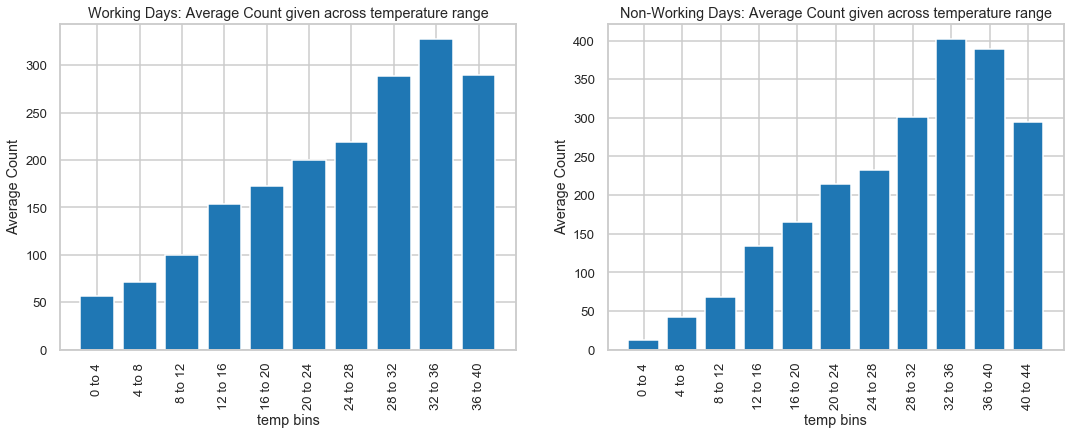

In [3]:
# Splitting data into working-day and non-working day
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

bin_size = 4
mydata_w['temp_round'] = mydata_w['temp']//bin_size
mydata_nw['temp_round'] = mydata_nw['temp']//bin_size

mean_count_vs_temp_w = mydata_w.groupby('temp_round')['count'].mean()
mean_count_vs_temp_nw = mydata_nw.groupby('temp_round')['count'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average Count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average Count given across temperature range')

plt.show()

**Observation**
* From the above histogram plot, we can see that there is a steady increase in the average bikes rented with temperature with a small decrease at the highest temperature bin

## Feature Engineering

Lets, split the datetime column into ['month', 'date', 'day', 'hour'] categories since the bike demand is more likely dependent on these individual categories. Creating these 4 additional category columns 

**Few Observations**
+ Higher biker rentals as weather is more clear and sunny. 
+ Just '1 hour' instance where there were rentals under heavy rain/snow condition. Two possibilities
    + Could be an outlier
    + Reservations made at a time when the weather was good. But weather conditions logged sometime later in the same hour when the conditions were heavy rains/snow
+ Bike reservations are lesser in Spring season compared to Summer and Fall
+ Lots of outlier points for a particular seasons or weather conditions. This is most likely due to variable distribution across the day

In [4]:
# Splitting datetime object into month, date, hour and day category columns
mydata['month'] = [x.month for x in mydata.index]
mydata['date'] = [x.day for x in mydata.index]
mydata['hour'] = [x.hour for x in mydata.index]
mydata['day'] = [x.weekday() for x in mydata.index]

testdata['month'] = [x.month for x in testdata.index]
testdata['date'] = [x.day for x in testdata.index]
testdata['hour'] = [x.hour for x in testdata.index]
testdata['day'] = [x.weekday() for x in testdata.index]

category_list = ['month', 'date', 'hour', 'day']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

In [5]:
# Converting into categorical data
category_list = ['season', 'holiday', 'workingday', 'weather']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

Mapping 0 to 6 day indices to Monday to Saturday 

In [6]:
# Mapping 0 to 6 day indices to Monday to Saturday 
day_dict = {0:'Monday', 1:'Teusday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
mydata['day'] = mydata['day'].map(day_dict)
testdata['day'] = testdata['day'].map(day_dict)

mydata.head(n=3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,date,hour,day
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,1,1,0,Saturday
2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,1,1,1,Saturday
2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,1,1,2,Saturday


## Hourly Distribution

Now that we have separated out the hour data, let us plot the distribution across hour in a day. Clearly, we expect to see some pattern in the distribution - for example, people would tend to rent bikes early in the morning and return them in the evening. 

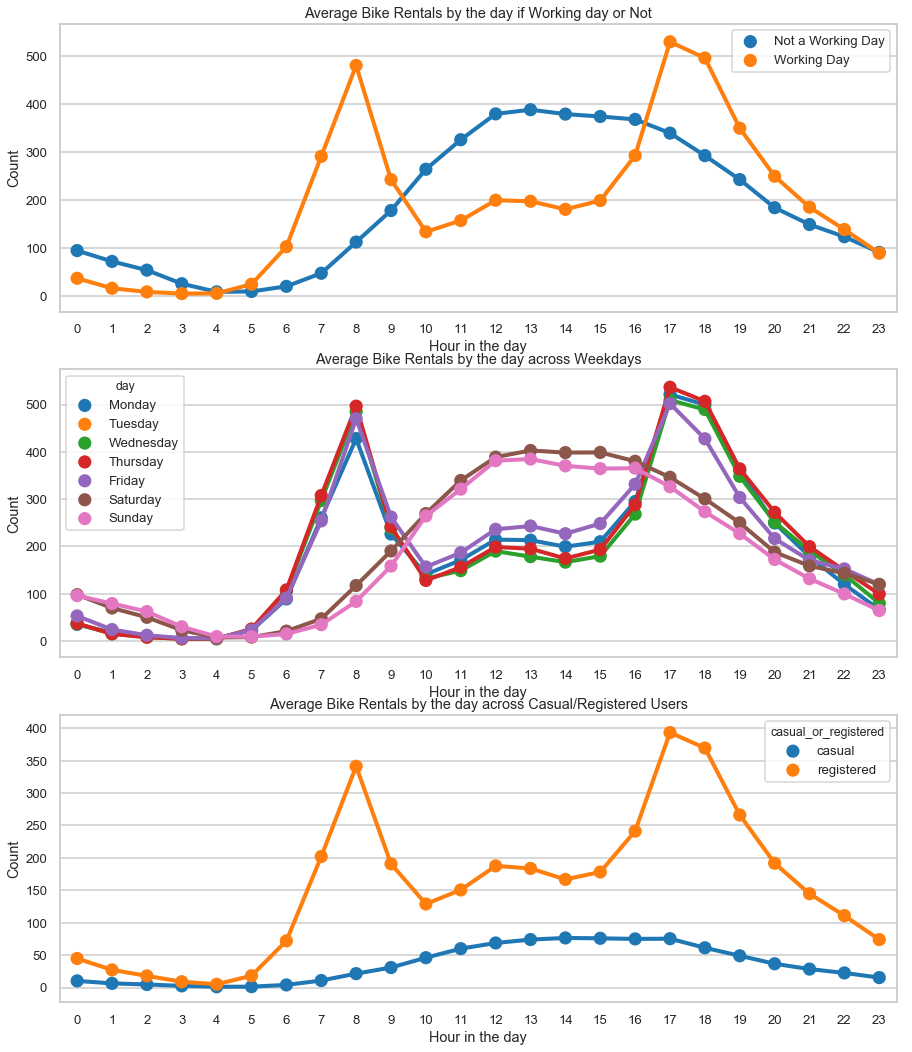

In [7]:
# Plots of average count across hour in a day for various categories

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(mydata.groupby(['workingday', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='hour', y='count', hue='workingday', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day if Working day or Not')

hue_order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(mydata.groupby(['day', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='hour', y='count', hue='day', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Weekdays')

df_melt = pd.melt(frame=mydata, id_vars='hour', value_vars=['casual', 'registered'], value_name='count', var_name='casual_or_registered')
group_casual_hour = pd.DataFrame(df_melt.groupby(['hour', 'casual_or_registered'])['count'].mean()).reset_index()
sns.pointplot(data=group_casual_hour, x='hour', y='count', hue='casual_or_registered', ax=axes[2])
axes[2].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Casual/Registered Users')

plt.show()

## Monthly Distribution

Now let us look at the average count of bike rentals across the months

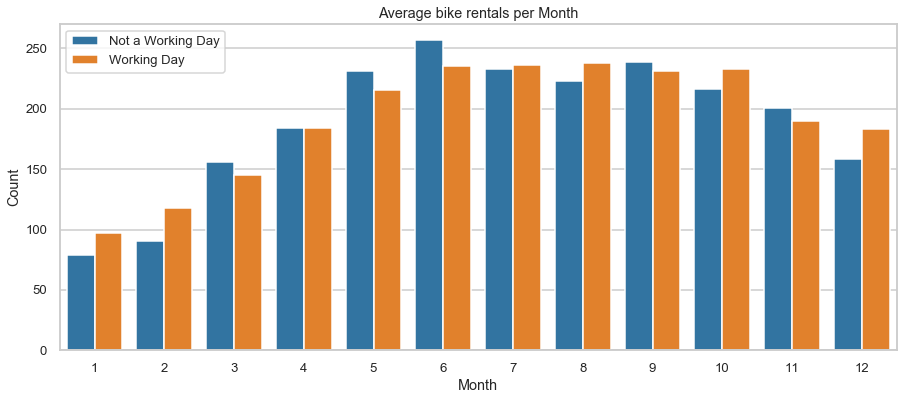

In [8]:
# Average Monthly Count Distribution plot
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(mydata.groupby(['month', 'workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='count', hue='workingday', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

**Observations**
* Lesser number of outliers can be seen in the seaborn box plot across hours indicating that most of the outliers are due to highly varying distribution during the day
* Higher reservations can be seen at around 8am and 5pm (office hours) and close to 0 reservations very early in the morning
* From the above plot we can see the 2 patterns across the hours in a day in bike rentals
    * Working Day: First pattern where there is a peak in the rentals at around 8am and another at around 5pm. These correspond to working local bikers who typically are ``registered`` and go to work on ``working day`` which are ``Monday`` to ``Friday``
    * Non Working Day: Second pattern where there is more or less a uniform rentals across the day with a peak at around noon time. These correspond to probably tourists who typically are ``casual`` users who rent/drop off bikes uniformly during the day and tour the city of Washington on ``non working days`` which typically are ``Saturday`` and ``Sunday``
* Also, we can see that we have more bike rentals during the Fall (July to September) and Summer (April to June) Season.

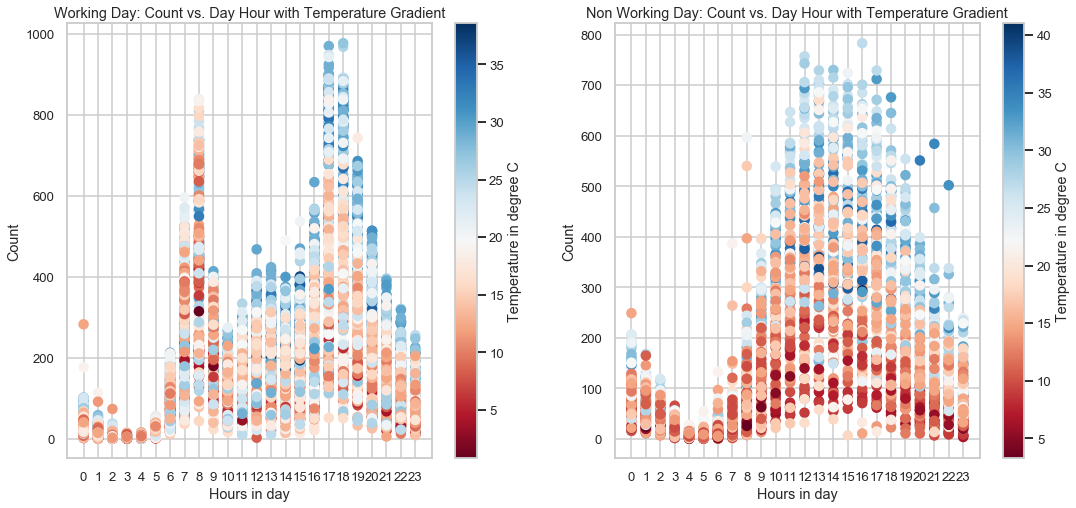

In [9]:
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

fig = plt.figure(figsize=(18, 8))
# Working Day
axes = fig.add_subplot(1, 2, 1)
f = axes.scatter(mydata_w.hour, mydata_w['count'], c=mydata_w.temp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

# Non Working Day
axes = fig.add_subplot(1, 2, 2)
f = axes.scatter(mydata_nw.hour, mydata_nw['count'], c=mydata_nw.temp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Non Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

plt.show()

**Observations**
* From the above, we can see that in general, more people tend to prefer biking at moderate to high temperatures; however, if the temperature is too hot (darkest of the blue dots), there is a small decline in count